# Introduction

La pratique de l'aviron en milieu naturel, comme sur les fleuves et rivières, dépend fortement des conditions hydrologiques telles que le débit et la hauteur d'eau. Ces paramètres jouent un rôle crucial dans la sécurité des rameurs, la qualité de l'expérience sportive, et l'organisation des entraînements et des compétitions. Toutefois, les variations du débit et de la hauteur d'eau, souvent influencées par les conditions météorologiques (pluies, sécheresses), rendent leur prévision essentielle pour les clubs d'aviron et leurs pratiquants. Ce projet, centré sur la Seine, vise donc à développer un modèle de prédiction fondé sur des données hydrométriques et météorologiques, permettant d'anticiper les conditions optimales pour la pratique de l'aviron ou à l'inverse de détecter ses potentiels dangers. En combinant l'analyse de données historiques, allant du 01/01/23 à aujourd'hui, avec des approches de modélisation, ce travail a pour objectif de fournir un outil fiable et pratique pour faciliter la planification et garantir la sécurité de la pratique sportive.

Ce projet comprend 3 grandes parties : 
- Dans la première partie, nous importons les bases de données utiles
- Dans la deuxième partie, nous étudions et analysons les données recueillies pour préparer le modèle prédictif
- Dans la troisième partie, nous modélisons le problème pour tenter d'y apporter une réponse satisfiasante

In [59]:
# !pip install cartopy
# !pip install geopy

In [1]:
import os
import requests

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import glob

from datetime import datetime, timedelta
from scipy.spatial import distance

In [2]:
os.chdir("/home/onyxia/work/Projet-de-Python-Leroux-Gisserot") # pour l'emplacement
os.environ["PROJ_LIB"] = "/opt/conda/share/proj" # pour les projections sur carte

# Data loading

Dans cette partie, nous importons de data.gouv.fr :
- des bases de données météo horaire pour chaque département
- une base de données concernant la hauteur d'eau et le débit des cours d'eau
- une base de données permettant de tracer ces cours d'eau sur une carte
- une base de données permettant de localiser les clubs d'aviron

In [57]:
from utils.data_loading import (
    read_csv_from_url, 
    load_department_data,
    load_and_save_all_department_data,
    load_data_from_disk,
    cleaning_and_organizing,
    get_coordinates,
    import_geojson_from_url,
    find_nearest_station,
    add_station_info_to_clubs,
)

---

Téléchargement des bases de données météo horaire, puis concaténation et nettoyage

In [4]:
'''
load_and_save_all_department_data(
    department_ids=["10", "27", "76", "77", "78", "91", "92", "95"], # départements par lesquels passe la Seine
    save_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24"
)
'''

'\nload_and_save_all_department_data(\n    department_ids=["10", "27", "76", "77", "78", "91", "92", "95"], # départements par lesquels passe la Seine\n    save_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24"\n)\n'

In [5]:
meteo_horaire = load_data_from_disk(data_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24")

Loading and concatenating data from disk: 100%|██████████| 8/8 [00:00<00:00,  9.87it/s]


In [6]:
meteo_horaire = cleaning_and_organizing(
                                df=meteo_horaire,
                                columns=["DEPARTMENT_ID", "NOM_USUEL", "AAAAMMJJHH"],
                                date="AAAAMMJJHH"
                            )

Le dataframe meteo_horaire contient les colonnes suivantes :
- DEPARTMENT_ID : le numéro du département où se trouve la station météo
- NUM_POSTE : l'identifiant de la station météo
- NOM_USUEL : le nom de la commune où se trouve la station météo
- LAT et LON : les coordonnées de la station météo
- AAAAMMJJHH : la date exacte, à l'heure près, de la collecte d'information
- RR1 : les précipitations tombées en une heure (en mm)
- T : la température moyenne enregistrée pendant cette heure

On crée ensuite 2 dataframes :
- l'un nous servira pour entraîner le modèle (données receuillies entre le 1er janvier 2023 et le 30 novembre 2024)
- l'autre nous servira à faire des prédictions effectives (données receuillies sur les 30 derniers jours)

In [7]:
date_limite = pd.to_datetime("2024-12-01 00:00:00")
meteo_horaire_train = meteo_horaire[meteo_horaire['AAAAMMJJHH'] < date_limite]

In [8]:
date_ajd = pd.to_datetime(datetime.now())
date_debut = date_ajd - timedelta(days=30)
meteo_horaire_pred = meteo_horaire[(meteo_horaire['AAAAMMJJHH'] > date_debut) & (meteo_horaire['AAAAMMJJHH'] <= date_ajd)]

---

Création du dataset clubs d'aviron et récupération de leurs coordonnées GPS

In [9]:
clubs_aviron = pd.read_csv('/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/adresses_clubs.csv', sep=';', header=0)

In [10]:
clubs_aviron[['LAT', 'LON']] = clubs_aviron['Adresse'].apply(get_coordinates)

---

Création du dataset stations hydrométriques

In [95]:
liste_stations_hydro = pd.read_csv('/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/liste-stations.csv', sep=';', header=0)
liste_stations_hydro = liste_stations_hydro.rename(columns={'cdentite': 'NUM_POSTE', 'lbstationhydro': 'NOM_USUEL', 'longitude': 'LON', 'latitude': 'LAT'})
liste_stations_hydro = liste_stations_hydro[~liste_stations_hydro["dtfermeture"].notna()] # Filtration des stations hydrométriques encore en activité
liste_stations_hydro = liste_stations_hydro.drop(['typestation', 'dtmiseservice', 'dtfermeture'], axis=1)

---

Ajout des stations météo et hydro les plus proches de chaque club d'aviron

In [12]:
stations_meteo_clubs = add_station_info_to_clubs(clubs_aviron, meteo_horaire, filter_keyword=None)
stations_meteo_clubs = stations_meteo_clubs.rename(columns={'NUM_POSTE': 'NUM_NWS', 'NOM_USUEL': 'NWS'}) # NWS = Nearest Weather Station

In [13]:
stations_hydro_clubs = add_station_info_to_clubs(clubs_aviron, liste_stations_hydro, filter_keyword='Seine')
stations_hydro_clubs = stations_hydro_clubs.rename(columns={'NUM_POSTE': 'NUM_NHS', 'NOM_USUEL': 'NHS'}) # NHS = Nearest Hydro Station

In [126]:
clubs_hydro_meteo = pd.merge(stations_meteo_clubs, stations_hydro_clubs, on=["Club", "Adresse", "LAT", "LON"], how="inner")

On en tire par là-même la liste des stations hydro dont il faut récupérer les données

In [91]:
station_ids = clubs_hydro_meteo['NUM_NHS'].drop_duplicates().tolist()

In [150]:
# Cleaning des datasets et insertion dans un dictionnaire pour y avoir accès à tous en même temps

# Chemin où se trouvent les fichiers de débit des stations hydrométriques
chemin_fichiers = "/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-flow-rate-23-24/*.csv"

# Chargement dans un dictionnaire
fichiers = glob.glob(chemin_fichiers)
dictionnaire_df_stations_hydro = {}

for fichier in fichiers :
    # Extraire le NUM_POSTE du nom du fichier
    NUM_POSTE = fichier.split("/")[-1].split(".")[0]
    df = pd.read_csv(fichier)

    #Création d'une colonne date time pour uniformiser avec les donénes météo ensuite)
    df['Datetime'] = pd.to_datetime(df['Date (TU)'].str.replace('Z', ''), format='%Y-%m-%dT%H:%M:%S.%f')
    # Supprimer les colonnes inutiles
    df = df.drop(columns=["Date (TU)", "Statut", "Qualification", "Méthode", "Continuité"], errors="ignore")
    df = df[['Datetime', 'Valeur (en m³/s)']]

    # Convertir la colonne "Valeur (en m³/s)" en entier
    df["Valeur (en m³/s)"] = pd.to_numeric(df["Valeur (en m³/s)"].astype(str).str.replace(",", "").str.replace('"', ""), errors="coerce").fillna(0).astype(int)
    

    dictionnaire_df_stations_hydro[NUM_POSTE] = df

# Vérification des clés  (à savoir les NUM_POSTE)
print("Numéros de postes hydrométriques disponibles :", dictionnaire_df_stations_hydro.keys())

Numéros de postes hydrométriques disponibles : dict_keys(['H170001001', 'F447000101', 'H512011001', 'H300000201', 'H308000101', 'F400000301', 'H080001101', 'F704000101', 'H320000104', 'H503011001', 'F449000601', 'F490000104', 'F712000102', 'F704000102', 'H501012001'])


Création du dictionnaire contenant les df des données météo : 

In [151]:
# 1. Charger tous les fichiers CSV d'un dossier spécifique
chemin_fichiers = '/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24/*.csv'
files = glob.glob(chemin_fichiers)

# 2. Créer un dictionnaire pour stocker les DataFrames par station
dictionnaire_df_stations_meteo = {}

# Parcourir chaque fichier CSV
for file in files:
    # Lire chaque fichier CSV
    df = pd.read_csv(file)
        
    # Convertir la colonne 'AAAAMMJJHH' en datetime
    df['Datetime'] = pd.to_datetime(df['AAAAMMJJHH'], format='%Y%m%d%H')
    
    # Sélectionner les colonnes nécessaires
    df_filtered = df[['Datetime', 'NUM_POSTE', 'T', 'RR1']]
    
    # Définir 'Datetime' comme index
    df_filtered.set_index('Datetime', inplace=True)
    
    # Parcourir chaque station (NUM_POSTE)
    for station_id in df_filtered['NUM_POSTE'].unique():
        # Filtrer les données pour cette station
        df_station = df_filtered[df_filtered['NUM_POSTE'] == station_id].drop(columns='NUM_POSTE')
    
        # Ajouter ou mettre à jour le DataFrame de la station dans le dictionnaire
        if station_id not in dictionnaire_df_stations_meteo:
            dictionnaire_df_stations_meteo[station_id] = df_station
        else:
            dictionnaire_df_stations_meteo[station_id] = pd.concat([dictionnaire_df_stations_meteo[station_id], df_station])

print("NUM_POSTE disponibles dans le dictionnaire :", dictionnaire_df_stations_meteo.keys())

NUM_POSTE disponibles dans le dictionnaire : dict_keys([np.int64(92073001), np.int64(76116001), np.int64(76130001), np.int64(76171001), np.int64(76208001), np.int64(76217001), np.int64(76228001), np.int64(76255002), np.int64(76259001), np.int64(76276001), np.int64(76302002), np.int64(76378001), np.int64(76473001), np.int64(76481001), np.int64(76540009), np.int64(76552001), np.int64(76582001), np.int64(76679001), np.int64(76746001), np.int64(27016001), np.int64(27056003), np.int64(27100001), np.int64(27112001), np.int64(27306001), np.int64(27347001), np.int64(27375001), np.int64(27422001), np.int64(91027002), np.int64(91103001), np.int64(91184001), np.int64(91200002), np.int64(91275001), np.int64(91405002), np.int64(78005002), np.int64(78354001), np.int64(78380001), np.int64(78481001), np.int64(78486002), np.int64(78505001), np.int64(78562001), np.int64(78620001), np.int64(78621001), np.int64(78640001), np.int64(78646002), np.int64(77054001), np.int64(77084001), np.int64(77113002), np.i

In [105]:
debit_horaire = load_data_from_disk(data_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-flow-rate-23-24")
debit_horaire = debit_horaire.rename(columns={'Date (TU)': 'AAAAMMJJHH', 'Valeur (en m³/s)': 'debit', 'NUM_POSTE': 'NUM_POSTE_H', 'NOM_USUEL': 'NOM_USUEL_H'})
debit_horaire = debit_horaire.drop(['Statut', 'Qualification', 'Méthode', 'Continuité'], axis=1)
debit_horaire['AAAAMMJJHH'] = pd.to_datetime(debit_horaire['AAAAMMJJHH'], utc=True).dt.tz_localize(None)

Loading and concatenating data from disk: 100%|██████████| 15/15 [00:00<00:00, 64.87it/s]


---

Importation de la base de données fluviales

In [15]:
'''
rivers = import_geojson_from_url(
                geojson_url="https://www.data.gouv.fr/fr/datasets/r/f354a037-4a4e-4e7e-804b-01278ab228c5",
                geojson_file="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/rivers.geojson"
            )
'''

# **Data analysis**

In [16]:
from utils.data_analysis import (
    carte_figures,
    trace_graphique,
    trace_graphique_multiple,
)

**1. Représentation graphique des fleuves, des stations météo et hydro, et des clubs d'aviron**

In [41]:
coord_ws = pd.merge(clubs_hydro_meteo, meteo_horaire, left_on='NUM_NWS', right_on='NUM_POSTE', how="inner")
coord_ws = coord_ws[["NUM_NWS", "NWS", "LAT_y", "LON_y"]].drop_duplicates()
coord_ws = coord_ws.rename(columns={'LAT_y': 'LAT', 'LON_y': 'LON'})

In [42]:
coord_hs = pd.merge(clubs_hydro_meteo, liste_stations_hydro, left_on='NUM_NHS', right_on='NUM_POSTE', how="inner")
coord_hs = coord_hs[["NUM_NHS", "NHS", "LAT_y", "LON_y"]].drop_duplicates()
coord_hs = coord_hs.rename(columns={'LAT_y': 'LAT', 'LON_y': 'LON'})

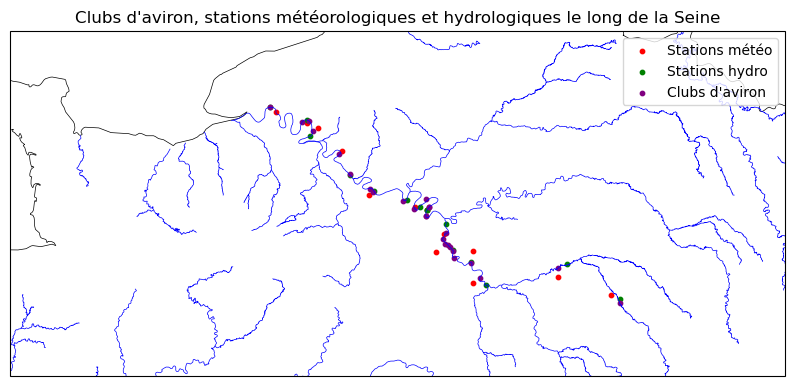

In [43]:
carte_figures(rivers, coord_ws, coord_hs, clubs_aviron)

On choisit à présent un club d'aviron, et indirectement, les stations météorologique et hydrologique les plus proches. Le reste de la partie a pour but de tracer différents graphiques (les précipitations, la température ou encore le débit en fonction du temps) pour tenter de remarquer des tendances ou des corrélations entres les variables.

In [49]:
nom_club = 'Emulation Nautique de Vernon'
nws = clubs_hydro_meteo.loc[clubs_hydro_meteo['Club'] == nom_club, 'NWS'].iloc[0]
nhs = clubs_hydro_meteo.loc[clubs_hydro_meteo['Club'] == nom_club, 'NHS'].iloc[0]
print(f'Les stations météo et hydro les plus proches de {nom_club} sont {nws} et {nhs}')

Les stations météo et hydro les plus proches de Emulation Nautique de Vernon sont LES ANDELYS et La Seine à Vernon - Station débitmétrique (>2006)


---

**2. Graphe des précipitations en fonction du temps**

2. a. <u>Heure par heure</u>

In [58]:
meteo_nws = meteo_horaire[meteo_horaire["NOM_USUEL"] == nws].copy()
meteo_nws = meteo_nws.dropna(subset=['RR1', 'T'])

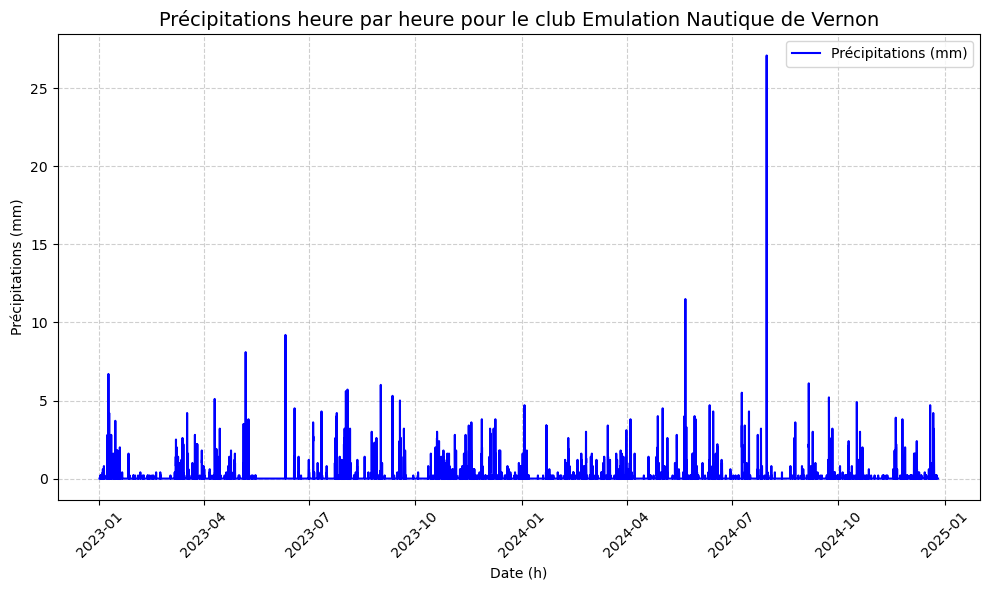

In [60]:
trace_graphique(
    x=meteo_nws["AAAAMMJJHH"],
    y=meteo_nws["RR1"],
    titre=f"Précipitations heure par heure pour le club {nom_club}",
    xlabel="Date (h)",
    ylabel="Précipitations (mm)",
)

Ce graphique détaille les précipitations enregistrées **heure par heure**. Il met en évidence la nature très variable des précipitations, avec de nombreux pics irréguliers.  
- Les pics isolés témoignent de périodes courtes mais **intenses de précipitation**.  
- Entre ces pics, les précipitations sont souvent nulles ou très faibles.  

Cette granularité **horaire**, utile pour analyser la variabilité des précipitations à court terme, rend difficile la lecture des **tendances globales** à cause de l'apparente saturation de l'information.

Pour un modèle de prévision du débit, ces données brutes heure par heure peuvent donc être **trop détaillées** pour être directement exploitées. En effet, les débits d'un cours d'eau dépendent davantage de cumuls sur des périodes plus longues (journées ou semaines) que d'événements ponctuels. Il faut de toute façon étudier l'impact que peut avoir une grosse averse, come observée vers août 2024, sur le débit de la Seine.

2. b. <u>Par semaine</u>

In [61]:
# On crée un dataframe où les précipitations sont sommées par semaine
meteo_nws['hebdo'] = meteo_nws['AAAAMMJJHH'].dt.to_period('W')
precipit_hebdo = meteo_nws.groupby('hebdo', as_index=False)['RR1'].sum()
precipit_hebdo['hebdo'] = precipit_hebdo['hebdo'].dt.to_timestamp(how='start')

# Puis on fait une moyenne glissante sur 3 semaines pour lisser la courbe
precipit_hebdo['moy_gliss'] = precipit_hebdo['RR1'].rolling(window=3, min_periods=1, center=True).mean()

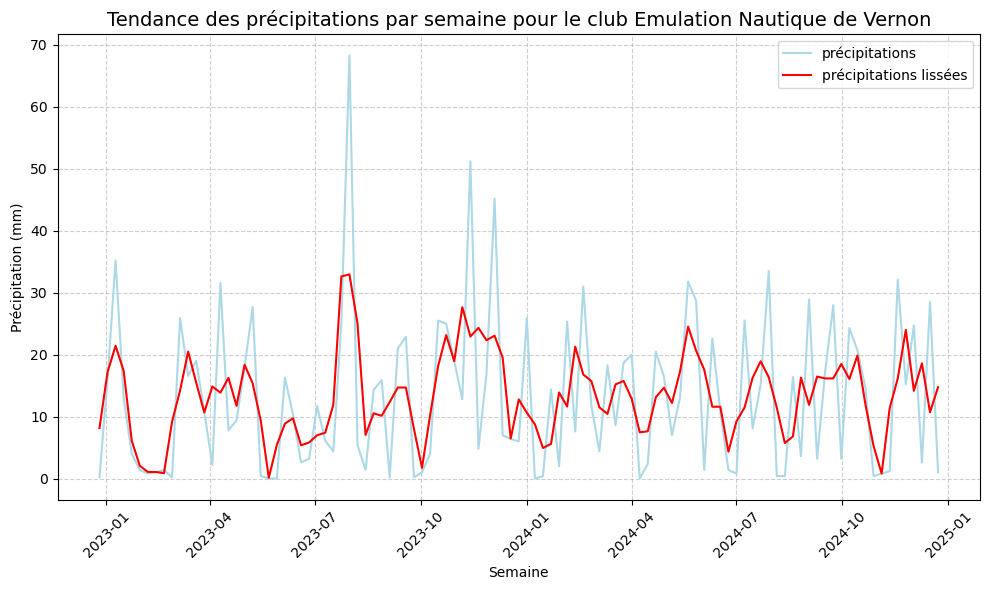

In [63]:
# Préparation des données pour la fonction
y_dico1 = {
    "précipitations": {"y": precipit_hebdo["RR1"], "color": "lightblue", "linestyle": "-"},
    "précipitations lissées": {"y": precipit_hebdo["moy_gliss"], "color": "red", "linestyle": "-"}
}

# Appel de la fonction
trace_graphique_multiple(
    x=precipit_hebdo["hebdo"],
    y_mult=y_dico1,
    titre=f'Tendance des précipitations par semaine pour le club {nom_club}',
    xlabel="Semaine",
    ylabel="Précipitation (mm)",
)

Ce graphique agrège les précipitations à une échelle **hebdomadaire**, ce qui permet de mieux identifier les **tendances globales** dans les précipitations :  
- En bleu clair : la somme hebdomadaire des précipitations montre les fluctuations globales des précipitations au fil du temps.  
- En rouge : la moyenne glissante sur 3 semaines lisse les variations hebdomadaires, révélant les tendances de fond sans être perturbée par des oscillations trop rapides.

Ce lissage est particulièrement utile pour **détecter les périodes humides ou sèches prolongées**, qui influencent directement le débit des cours d'eau. On observe plusieurs pics significatifs sur l'année 2023 (notamment au printemps et en automne), ce qui est cohérent avec les périodes de précipitations accrues.  

Les **sommations hebdomadaires** permettent de mieux **relier les précipitations aux variations de débit**, car elles intègrent une échelle temporelle plus pertinente pour l'évolution du niveau d'eau. La **moyenne glissante** aide à anticiper les périodes où les cours d'eau risquent d'atteindre des niveaux élevés, en réponse à des cumuls prolongés.

---

Pour **prédire le débit d'un cours d'eau**, il serait pertinent d'utiliser les données hebdomadaires comme **variable explicative principale**, en intégrant les tendances de fond issues de la moyenne glissante pour améliorer les prédictions.

---

**3. Graphe des températures en fonction du temps**

3. a. <u>Heure par heure</u>

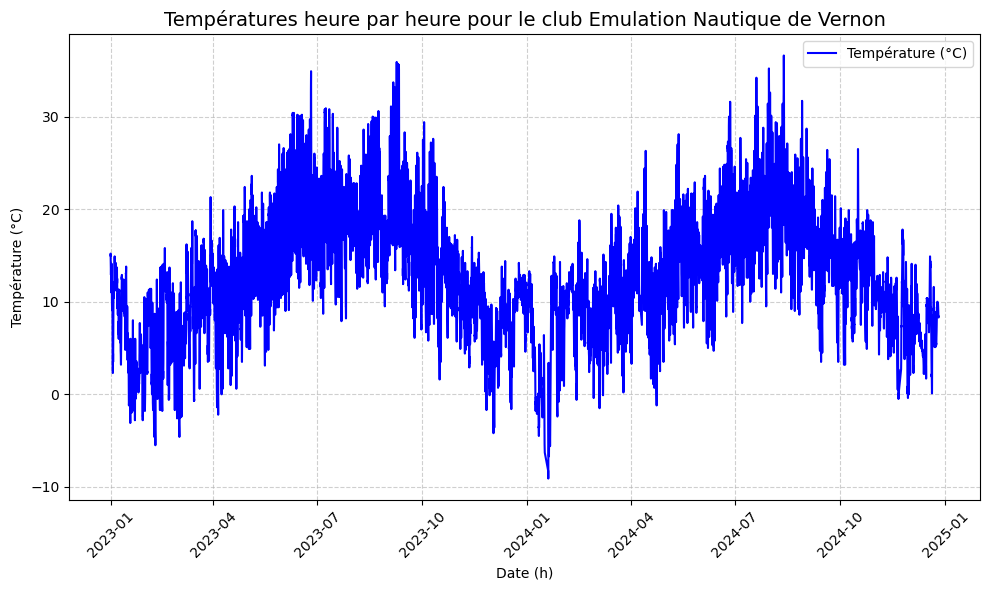

In [67]:
trace_graphique(
    x=meteo_nws["AAAAMMJJHH"],
    y=meteo_nws["T"],
    titre=f"Températures heure par heure pour le club {nom_club}",
    xlabel="Date (h)",
    ylabel="Température (°C)",
)

Ce graphique montre l'évolution de la température en fonction du temps à une résolution horaire. Il met à la fois en évidence les tendances globales de température en fonction des saisons (20-25°C vers juillet-août aussi bien en 2023 qu'en 2024, autour de 5°C en janvier-février) et la variabilité journalière des températures.

**Saisonnalité temporelle** : ce type de comportement est crucial pour la prédiction des débits, car les températures influencent l'évaporation, la fonte des neiges, et potentiellement le débit des cours d'eau.

**Variabilité horaire** : les fluctuations à court terme de la température sont visibles sous forme de variations rapides autour de la tendance globale. Ces variations peuvent être liées à des événements météorologiques locaux (comme des fronts froids ou chauds) qui affectent aussi les précipitations et, par extension, les débits des rivières.

**Implication pour la prédiction du débit** : les températures, combinées aux précipitations, influencent directement le débit par la fonte des neiges, l'infiltration dans les sols, et l'évaporation. Ces variations saisonnières et horaires de température doivent donc être intégrées comme une variable explicative dans le modèle de prédiction.

3. b. <u>Par semaine</u>

In [69]:
# On reproduit la même méthode que pour les précipitations
temp_hebdo = meteo_nws.groupby('hebdo', as_index=False)['T'].mean()
temp_hebdo['hebdo'] = temp_hebdo['hebdo'].dt.to_timestamp(how='start')
temp_hebdo['moy_gliss'] = temp_hebdo['T'].rolling(window=3, min_periods=1, center=True).mean()

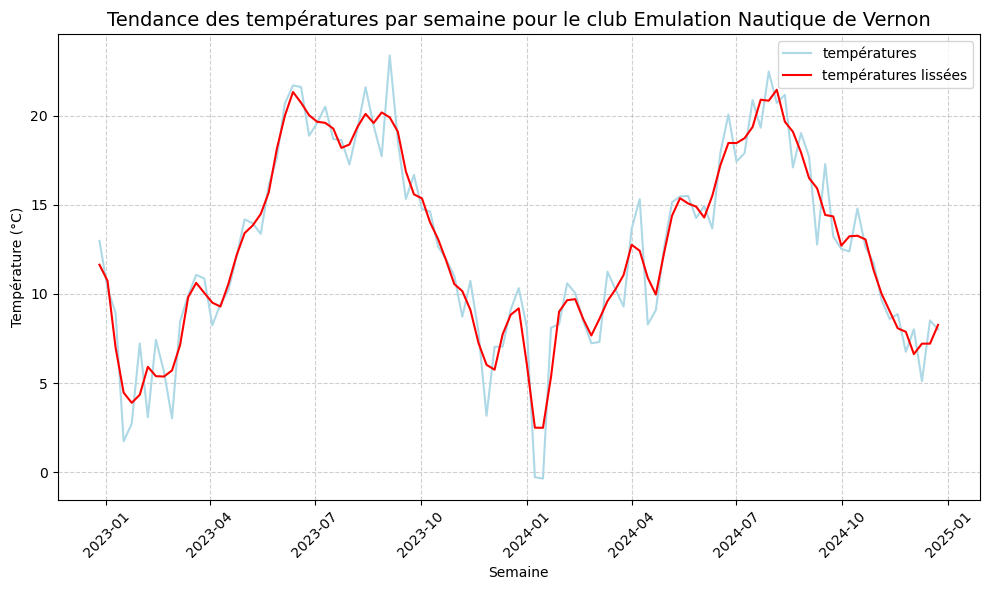

In [72]:
# Préparation des données pour la fonction
y_dico2 = {
    "températures": {"y": temp_hebdo["T"], "color": "lightblue", "linestyle": "-"},
    "températures lissées": {"y": temp_hebdo["moy_gliss"], "color": "red", "linestyle": "-"}
}

# Appel de la fonction
trace_graphique_multiple(
    x=temp_hebdo["hebdo"],
    y_mult=y_dico2,
    titre=f'Tendance des températures par semaine pour le club {nom_club}',
    xlabel="Semaine",
    ylabel="Température (°C)",
)

Ici, on se restreint à la compréhension des tendances globales de températures. Cette restriction permet pas de voir de corrélation directe avec les précipitations. Les températures et les précipitations jouent donc probablement leur rôle dans la prédiction du débit des cours d'eau de manière indépendante.

Mais on peut d'ores-et-déjà émettre quelques hypothèses : 
- plus les précipitations sont importantes et plus elles durent longtemps, plus le débit sera élevé, ceteris paribus
- plus la température est élevée et plus la période de chaleur est longue, plus le débit sera faible, ceteris paribus
- plus la température est élevée, plus les précipitations ont un impact positif sur le débit (par ruissellement)

**4. Graphe du débit en fonction du temps**

In [115]:
debit_nhs = debit_horaire[debit_horaire["NOM_USUEL_H"] == nhs].copy()
debit_nhs = debit_nhs.dropna(subset='debit')

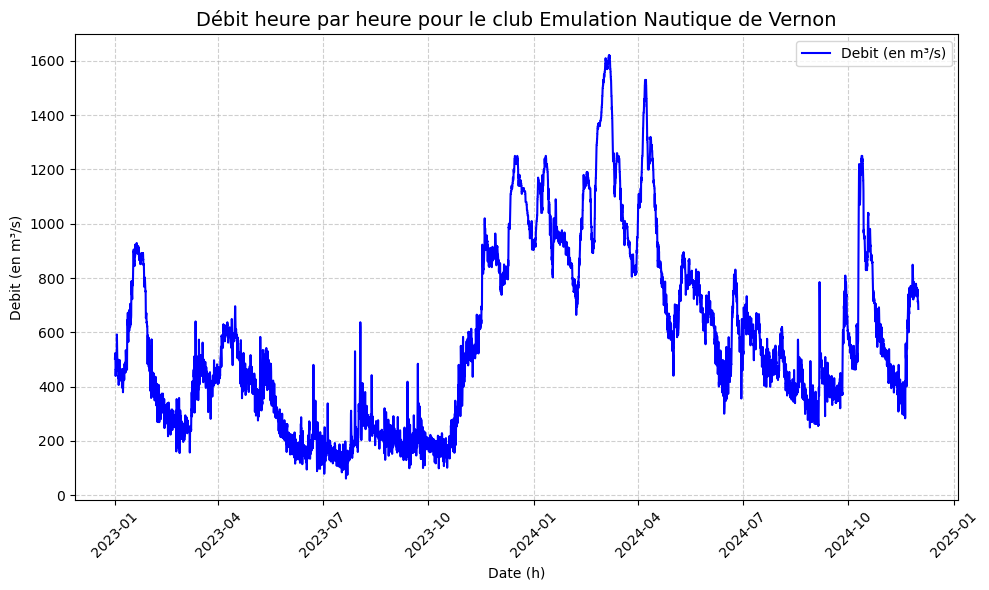

In [116]:
trace_graphique(
    x=debit_nhs["AAAAMMJJHH"],
    y=debit_nhs["debit"],
    titre=f"Débit heure par heure pour le club {nom_club}",
    xlabel="Date (h)",
    ylabel="Debit (en m³/s)",
)

In [118]:
# On reproduit la même méthode que pour les précipitations
debit_nhs['hebdo'] = debit_nhs['AAAAMMJJHH'].dt.to_period('W')
debit_hebdo = debit_nhs.groupby('hebdo', as_index=False)['debit'].mean()
debit_hebdo['hebdo'] = debit_hebdo['hebdo'].dt.to_timestamp(how='start')
debit_hebdo['moy_gliss'] = debit_hebdo['debit'].rolling(window=3, min_periods=1, center=True).mean()

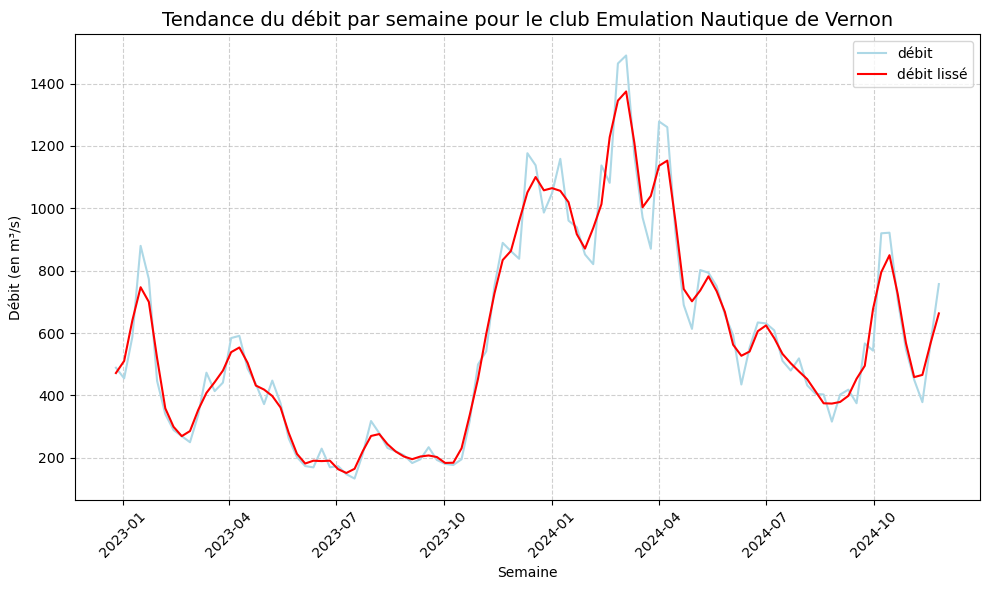

In [119]:
# Préparation des données pour la fonction
y_dico2 = {
    "débit": {"y": debit_hebdo["debit"], "color": "lightblue", "linestyle": "-"},
    "débit lissé": {"y": debit_hebdo["moy_gliss"], "color": "red", "linestyle": "-"}
}

# Appel de la fonction
trace_graphique_multiple(
    x=debit_hebdo["hebdo"],
    y_mult=y_dico2,
    titre=f'Tendance du débit par semaine pour le club {nom_club}',
    xlabel="Semaine",
    ylabel="Débit (en m³/s)",
)

# **Data modeling**

On crée dorénavant un gros dataframe avec toutes les données qui serviront pour l'entraînement du modèle :
- le club d'aviron
- ses coordonnées GPS
- les station météo et hydro les plus proches
- l'heure de prélèvement des données
- le débit, les précipitations et la température à cette heure

In [165]:
# Étape 1: Joindre les données de debit_horaire avec clubs_hydro_meteo sur NUM_NHS
debit_club = debit_horaire.merge(
    clubs_hydro_meteo[['Club', 'LAT', 'LON', 'NUM_NHS', 'NHS']],
    left_on='NUM_POSTE_H',
    right_on='NUM_NHS',
    how='inner'
)

# Étape 2: Joindre les données de meteo_horaire avec clubs_hydro_meteo sur NUM_NWS
meteo_club = meteo_horaire.merge(
    clubs_hydro_meteo[['Club', 'LAT', 'LON', 'NUM_NWS', 'NWS']],
    left_on='NUM_POSTE',
    right_on='NUM_NWS',
    how='inner'
)

# Étape 3: Combiner les deux DataFrames sur le Club et la colonne temporelle 'AAAAMJJHH'
combined = debit_club.merge(
    meteo_club,
    on=['Club', 'AAAAMMJJHH'],
    suffixes=('_hydro', '_meteo')
)

# Étape 4: Sélectionner les colonnes pertinentes
result = combined[['Club', 'LAT', 'LON', 'NHS', 'NWS', 'AAAAMMJJHH', 'debit', 'RR1', 'T']].copy()

# Étape 5: Renommer pour une meilleure lisibilité
result.rename(columns={
    'LAT': 'LAT_Club',
    'LON': 'LON_Club'
}, inplace=True)

# Affichage du DataFrame final
result

,Club,LAT_Club,LON_Club,NHS,NWS,AAAAMMJJHH,debit,RR1,T
0,Cercle d'Aviron Nogentais,48.500744,3.507613,La Seine à Pont-sur-Seine,BOUY-SUR-ORVIN,2023-01-01 00:00:00,66.9,0.0,14.6
1,Cercle d'Aviron Nogentais,48.500744,3.507613,La Seine à Pont-sur-Seine,BOUY-SUR-ORVIN,2023-01-01 01:00:00,66.7,0.0,13.8
2,Cercle d'Aviron Nogentais,48.500744,3.507613,La Seine à Pont-sur-Seine,BOUY-SUR-ORVIN,2023-01-01 02:00:00,66.6,0.0,14.2
3,Cercle d'Aviron Nogentais,48.500744,3.507613,La Seine à Pont-sur-Seine,BOUY-SUR-ORVIN,2023-01-01 03:00:00,66.4,0.0,13.9
4,Cercle d'Aviron Nogentais,48.500744,3.507613,La Seine à Pont-sur-Seine,BOUY-SUR-ORVIN,2023-01-01 04:00:00,66.2,0.0,13.6
...,...,...,...,...,...,...,...,...,...
386965,Club nautique de Belbeuf,49.370154,1.127481,La Seine à Oissel,ROUEN-BOOS,2024-11-30 19:00:00,1062,0.0,5.9
386966,Club nautique de Belbeuf,49.370154,1.127481,La Seine à Oissel,ROUEN-BOOS,2024-11-30 20:00:00,1064,0.0,6.6
386967,Club nautique de Belbeuf,49.370154,1.127481,La Seine à Oissel,ROUEN-BOOS,2024-11-30 21:00:00,1058,0.0,6.5
386968,Club nautique de Belbeuf,49.370154,1.127481,La Seine à Oissel,ROUEN-BOOS,2024-11-30 22:00:00,1057,0.0,6.4
